#**ARIMA模型**

## AR（AutoRegression)模型
自回归模型描述当前值与历史值之间的关系，用变量自身的历史时间数据对自身进行预测。

一般P阶的自回归模型AR:
$$X_t=\alpha_1{X_{t-1}}+\alpha_2{X_{t-2}}+...+\alpha_p{X_{t-p}}+u_t$$

如果随机扰动项是一个白噪声，则成为一个纯AR(p)过程，记为：
$$X_t=\alpha_1{X_{t-1}}+\alpha_2{X_{t-2}}+...+\alpha_p{X_{t-p}}+\varepsilon_t$$

自回归模型首先要确定一个阶数p，表示用几期的历史值来预测当前值。

自回归模型有很多的限制：
- 用自身数据
- 时间序列必须具有平稳性
- 只是用于预测与自身前期相关的现象（序列具有自相关性）


## MA（MovingAverage)模型
在AR模型中，如果$u_t$不是一个白噪声，通常认为他是一个q阶的移动平均。即：
$$u_t = \varepsilon_t+\beta_1\varepsilon_{t-1}+...+\beta_q\varepsilon_{t-q}$$
$\varepsilon_t$为白噪声序列。
特别的，当$X_t=u_t$，即时间序列的当前值与历史值没有关系，而只依赖于白噪声的线性组合，就得到了MA模型。
$$X_t=\varepsilon_t+\beta_1\varepsilon_{t-1}+...+\beta_q\varepsilon_{t-q}$$

**需指出一点，AR模型中，历史白噪声的影响是间接影响当前预测值的（通过影响历史时序值）**


## ARMA模型
将AR(p)和MA(q)结合，就得到了一般的自回归移动模型：ARMA(p,q)
$$X_t=\alpha_1{X_{t-1}}+\alpha_2{X_{t-2}}+...+\alpha_p{X_{t-p}}+\varepsilon_t+\beta_1\varepsilon_{t-1}+...+\beta_q\varepsilon_{t-q}$$

该式表明：
- 一个随机时间序列可以通过一个自回归移动模型来表示，即该序列可以由其自身的过去值或滞后值以及随机扰动来解释。
- 如果该序列是平稳的，即他的行为并不会随着时间的推移而变化，那么我们就可以通过该序列过去的行为来预测未来。

## ARIMA模型
将回归模型（AR）,移动平均模型（MA)和差分法结合，我们就得到了差分自回归移动平均模型ARIMA(p,d,q)，其中d是需要对数据进行差分的阶数。






接下来，我们来看一个是实战：

生成ARIMA模型的基本步骤：
- 对序列绘图，进行ADF检验，观察序列是否平稳；对于非平稳时间序列要先进行d阶差分，转化为平稳时间序列。
- 对平稳时间序列分别求其自相关系数和偏自相关系数，拖过对自相关图和偏自相关图的分析，得到最佳的p和q。
- 由以上得到的p，d，q，得到ARIMA模型，然后对模型进行模型检验。


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


             total_purchase_amt  total_redeem_amt
report_date                                      
20130701               32488348           5525022
20130702               29037390           2554548
20130703               27270770           5953867
20130704               18321185           6410729
20130705               11648749           2763587
***
   report_date  total_purchase_amt  total_redeem_amt
0     20130701            32488348           5525022
1     20130702            29037390           2554548
2     20130703            27270770           5953867
3     20130704            18321185           6410729
4     20130705            11648749           2763587
***
  report_date  total_purchase_amt  total_redeem_amt
0  2013-07-01            32488348           5525022
1  2013-07-02            29037390           2554548
2  2013-07-03            27270770           5953867
3  2013-07-04            18321185           6410729
4  2013-07-05            11648749           2763587
***
        

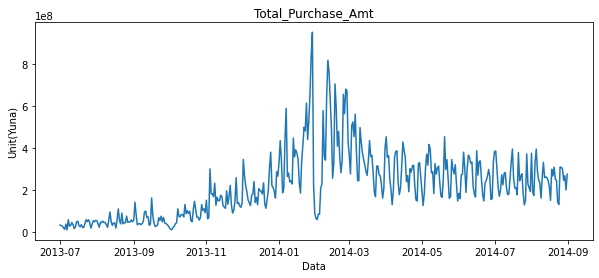

In [ ]:
user_balance = pd.read_csv("user_balance_table.csv")

df_tmp = user_balance.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
df_tmp.reset_index(inplace=True)
df_tmp['report_date'] = pd.to_datetime(df_tmp['report_date'], format='%Y%m%d')
df_tmp.index = df_tmp['report_date']

total_purchase_amt = plt.figure(figsize=(10,4))
ax = total_purchase_amt.add_subplot(111)
ax.set(title='Total_Purchase_Amt', ylabel='Unit(Yuna)', xlabel='Data')
plt.plot(df_tmp['report_date'], df_tmp['total_purchase_amt'])
plt.show()

我们去20140401-20140731之间的数据作为训练集，20140801-20140810之间的数据为测试集：

In [ ]:
import pandas as pd
import datetime

In [ ]:
def generate_purchase_seq():
  dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y%m%d')
  user_balance = pd.read_csv('user_balance_table.csv', parse_dates=['report_date'], index_col='report_date', date_parser=dateparse)
  df = user_balance.groupby(['report_date'])['total_purchase_amt'].sum()
  purchase_seq = pd.Series(df, name='value')

  purchase_seq_train = purchase_seq['2014-04-01':'2014-07-31']
  purchase_seq_test = purchase_seq['2014-08-01':'2014-08-10']

  purchase_seq_train.to_csv('purchase_seq_train.csv', header=True)
  purchase_seq_test.to_csv('purchase_sqp_test.csv', header=True)

In [ ]:
generate_purchase_seq()

查看一下训练集的差分效果，并对每一次差分结果做ADF检验。

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

In [ ]:
def diff(timeseries):
  timeseries_diff1 = timeseries.diff(1)
  timeseries_diff2 = timeseries_diff1.diff(1)

  timeseries_diff1 = timeseries_diff1.fillna(0)
  timeseries_diff2 = timeseries_diff2.fillna(0)

  timeseries_adf = ADF(timeseries['value'].tolist())
  timeseries_diff1_adf = ADF(timeseries_diff1['value'].tolist())
  timeseries_diff2_adf = ADF(timeseries_diff2['value'].tolist())

  print('timeseries_adf: ', timeseries_adf)
  print('timeseries_diff1_adf: ', timeseries_diff1_adf)
  print('timeseries_diff2_adf: ', timeseries_diff2_adf)

  plt.figure(figsize=(12,8))
  plt.plot(timeseries, label='Original', color='blue')
  plt.plot(timeseries_diff1, label='Diff1', color='red')
  plt.plot(timeseries_diff2, label='Diff2', color='purple')
  plt.legend(loc='best')
  plt.show() 

timeseries_adf:  (-2.0639747511769886, 0.2592449964335159, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4191.005978668394)
timeseries_diff1_adf:  (-6.542516143607565, 9.270661450976566e-09, 12, 109, {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}, 4193.843107210291)
timeseries_diff2_adf:  (-5.615545867454482, 1.176695595662961e-06, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4222.922633673088)


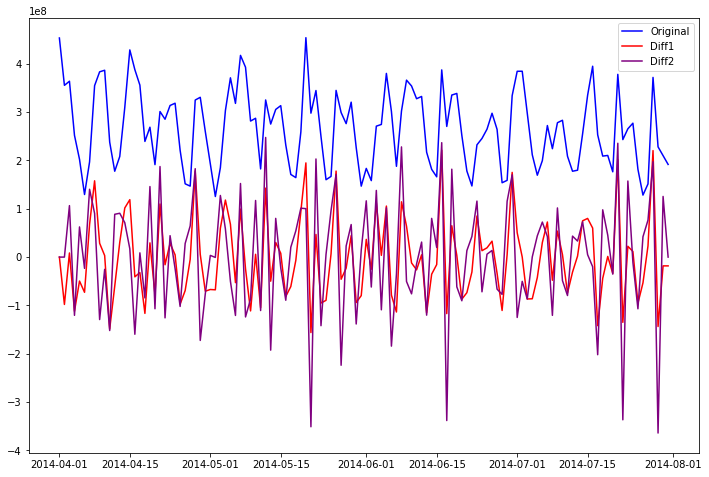

In [ ]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('purchase_seq_train.csv', parse_dates=['report_date'],index_col='report_date' ,date_parser=dateparse)
diff(purchase_seq_train)

从上图可知，若想使得序列变得平稳，需进行一阶差分。我们对序列进行一阶差分，并查看差分后序列的ACF,PACF：


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

def autocorrelation(timeseries, lags):
  fig = plt.figure(figsize=(12,8))
  ax1 = fig.add_subplot(211)
  sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
  ax2 = fig.add_subplot(212)
  sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
  plt.show()

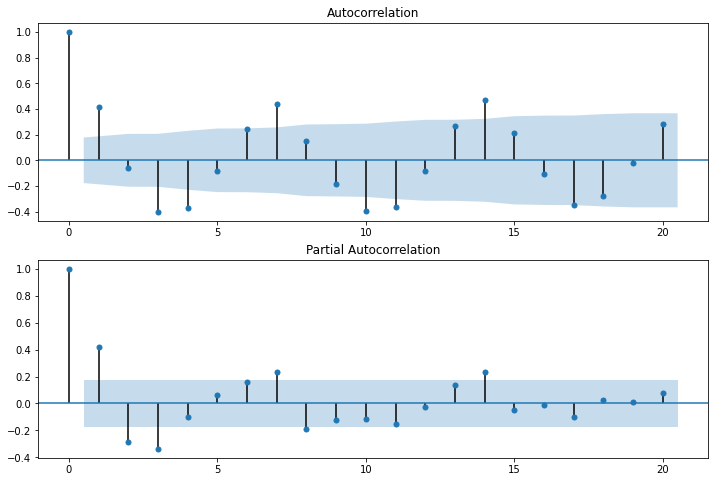

In [ ]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('purchase_seq_train.csv', parse_dates=['report_date'],index_col='report_date' ,date_parser=dateparse)
purchase_seq_train_diff = purchase_seq_train.diff(1)
purchase_seq_train_diff = purchase_seq_train_diff.fillna(0)

autocorrelation(purchase_seq_train, 20)

如何来确定AR(p)的p值，MA(q)的q值呢？

**拖尾和截尾**  
拖尾：指序列以指数率单调递减或者震荡衰减（在某阶后均为0）
截尾：是指序列从某个时点变得非常小。（在某阶后不均为0）

详情参见下方讲解：
[link text](https://www.jianshu.com/p/f9e4cfc69e12)

**p，q阶数的确定**  

模型（序列）  AR(p)        MA(q)        ARMA(p,q)  
自相关        拖尾         截尾（q）    拖尾  
偏相关        截尾（p）    拖尾         拖尾  

从序列ACF，PACF的图中没有发现明显的拖尾或截尾，说明对于这样的序列并不适合用ARIMA模型来拟合。  
如何用ARIMA模型来拟合这样的曲线呢？  
这里，**我们将先通过对时间序列分解（STL），在采用ARIMA模型来拟合趋势序列与残差序列。**

In [ ]:
def decomposing(timeseries):
  deconposition = seasonal_decompose(timeseries)
  trend = deconposition.trend
  seasonal = deconposition.seasonal
  residual = deconposition.resid

  plt.figure(figsize=(16,21))
  plt.subplot(411)
  plt.plot(timeseries, label='Original')
  plt.legend(loc='best')
  plt.subplot(412)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(413)
  plt.plot(seasonal, label='Seasonarity')
  plt.legend(loc='best')
  plt.subplot(414)
  plt.plot(residual, label='Residual')
  plt.legend(loc='best')
  plt.show()

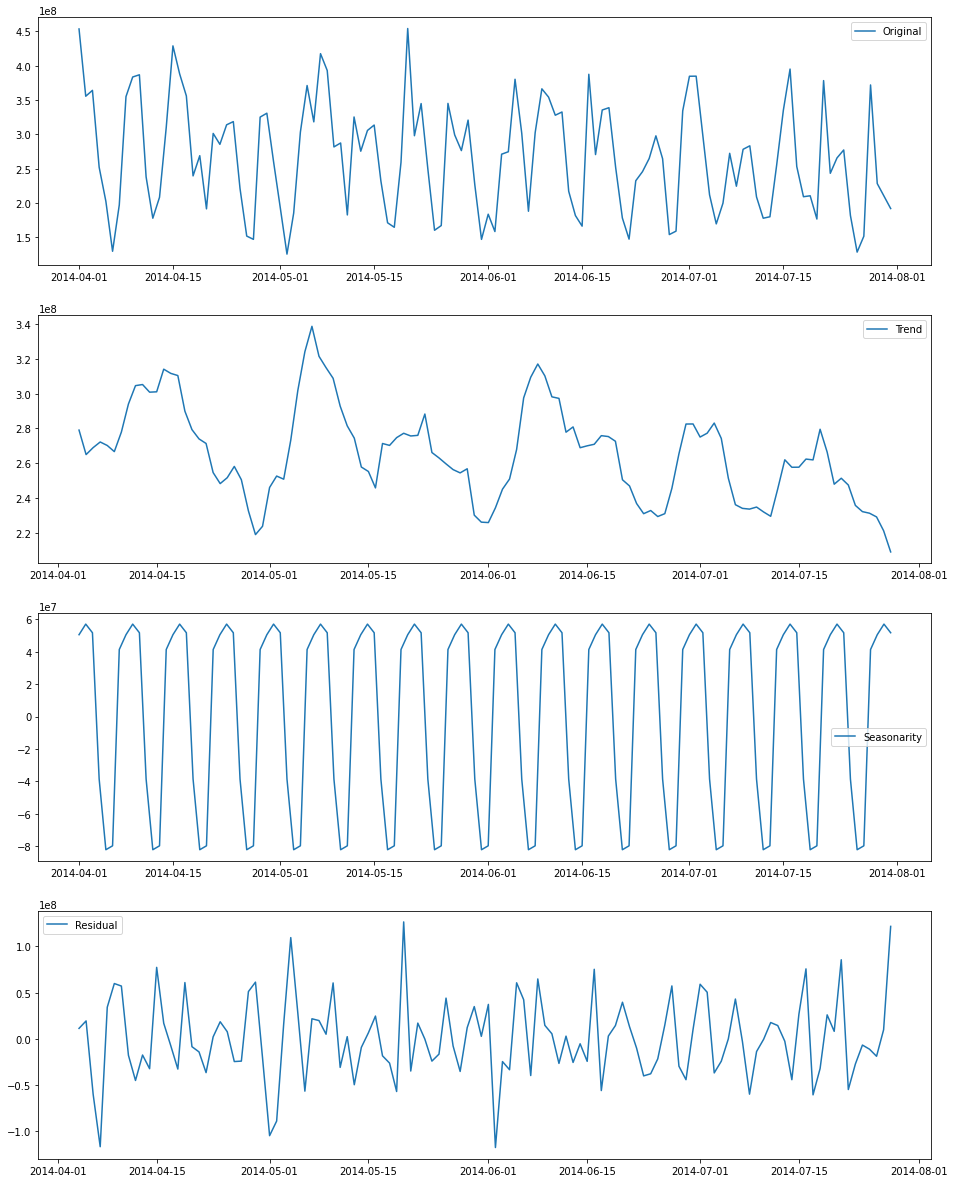

In [ ]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('purchase_seq_train.csv', parse_dates=['report_date'], index_col='report_date', date_parser=dateparse)
decomposing(purchase_seq_train)

从上图可以看出，原序列有明显的周期性，而且是以7天为一个周期，因此我们只对趋势序列和残差序列去拟合，同时认为这样的周期性会延伸至2014-08-01~2014-08-10的测试集上。
下面，将介绍对趋势序列，残差序列的拟合过程：


timeseries_adf:  (-3.236848758448588, 0.0179483836658815, 0, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 3971.5751227480287)
timeseries_diff1_adf:  (-10.571816201699766, 7.2723798146224e-19, 0, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 3970.0252957725997)
timeseries_diff2_adf:  (-5.522044427904821, 1.8681654787397836e-06, 8, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 3975.173191562041)


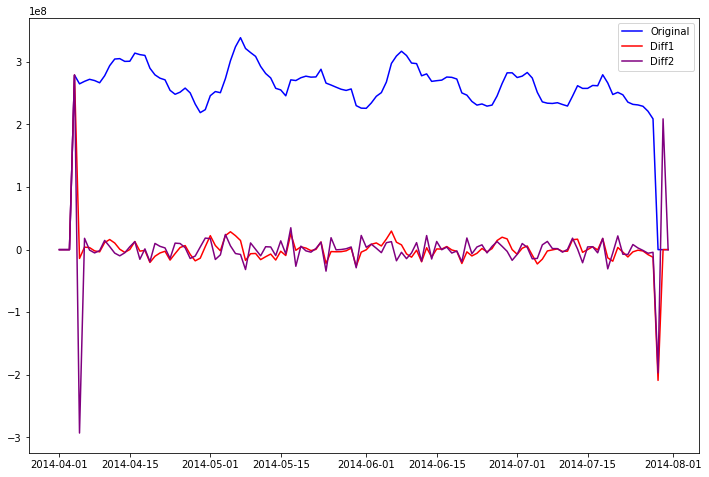

timeseries_adf:  (-6.29021210464835, 3.614727756796327e-08, 8, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 4080.577975834708)
timeseries_diff1_adf:  (-5.903150268380988, 2.7477376300417324e-07, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4107.235275181308)
timeseries_diff2_adf:  (-6.64472687864473, 5.3007963991348545e-09, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4137.527983157887)


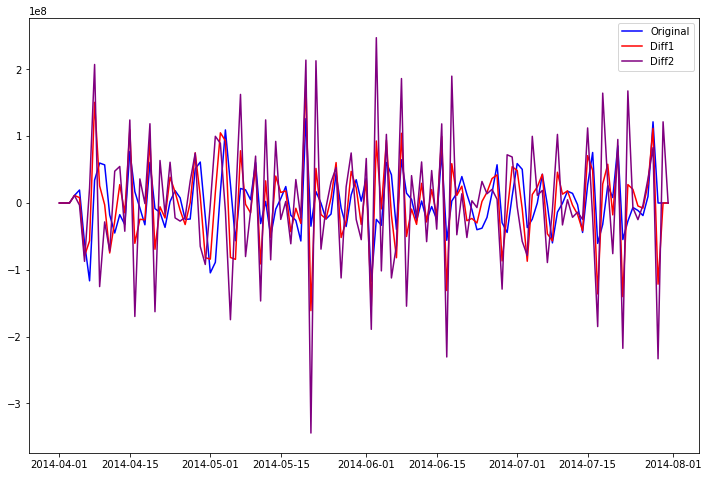

In [ ]:
dateparse = lambda dates: datetime.datetime.strptime(dates, "%Y-%m-%d")
purchase_seq_train = pd.read_csv('purchase_seq_train.csv', parse_dates=['report_date'],index_col='report_date', date_parser=dateparse)
decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

diff(trend)
diff(residual)

从上图结果上来看，趋势序列和残差序列都已经比较平稳了，因此不需要进行差分。

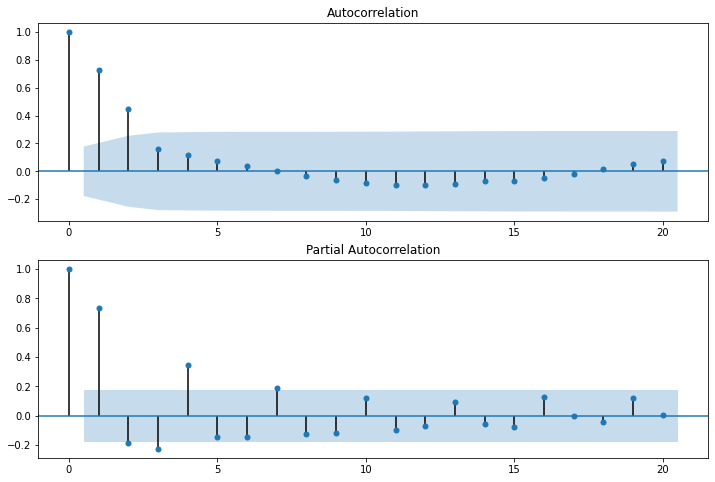

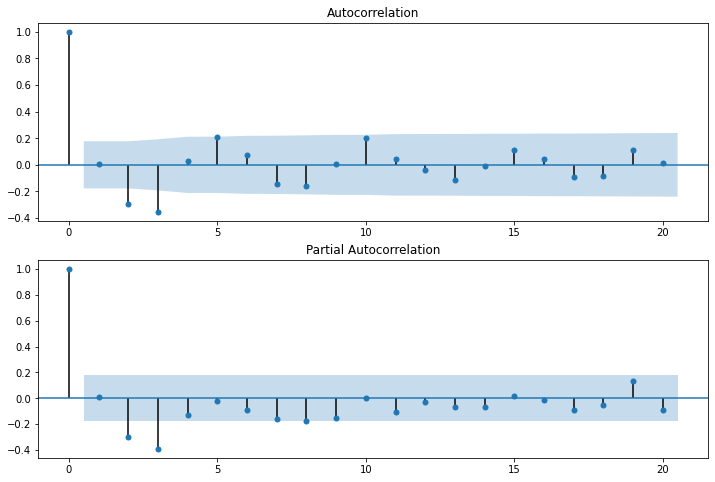

In [ ]:
dateparse = lambda dates: datetime.datetime.strptime(dates, "%Y-%m-%d")
purchase_seq_train = pd.read_csv('purchase_seq_train.csv', parse_dates=['report_date'],index_col='report_date', date_parser=dateparse)
decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

autocorrelation(trend, 20)
autocorrelation(residual, 20)

从上图可以看出：
 - 趋势序列ACF有3阶截尾，PACF有2阶拖尾，因此p=2，q=3
 - 残差序列ACF有4阶拖尾，PACF有4阶截尾，因此p=4，q=4

 通过拖尾和截尾对模型定阶，具有很强的主观性。
 回顾一下我们对模型参数估计的方法，是通过对损失和正则项的加权平均评估。我们在参数选择的时候，需要平衡预测误差与模型复杂度。我们可以根据信息准则函数法，来确定模型的阶数，这里介绍AIC和BIC准则

**AIC准则**  
全称：最小化信息量准则（Akaike Information Criterion）  
$$AIC = -2ln(L) + 2K$$
其中，L表示模型的极大似然函数，K表示模型参数的个数。

AIC准则存在一定的不足。当样本容量很大时，在AIC准则中拟合误差提供的信息就要受到样本容量的放大，而参数个数的惩罚因子却和样本容量没关系（一直是2），因此当样本容量很大时，使用AIC不收敛于真是模型，它通常比真是模型所含的未知个数要多。

**BIC准则**  
全称：贝叶斯信息准则（Bayesian Information Criterion）
$$BIC = -2ln(L) + Kln(n)$$
其中n表示样本容量。

显然，这两个评价指标越小越好。我们通过网络搜索， 确定AIC，BIC最有模型（p，q）

In [ ]:
import statsmodels.api as sm

dateparse = lambda dates: datetime.datetime.strptime(dates, "%Y-%m-%d")
purchase_seq_train = pd.read_csv('purchase_seq_train.csv', parse_dates=['report_date'],index_col='report_date', date_parser=dateparse)
decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

trend_evaluate = sm.tsa.arma_order_select_ic(trend, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('trend AIC', trend_evaluate.aic_min_order)
print('trend BIC', trend_evaluate.bic_min_order)

residual_evaluate = sm.tsa.arma_order_select_ic(residual, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('residual AIC', residual_evaluate.aic_min_order)
print('residual BIC', residual_evaluate.bic_min_order)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianI

trend AIC (1, 0)
trend BIC (1, 0)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


residual AIC (2, 1)
residual BIC (2, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


从评价准则的结果来看（这里采用的是AIC结果）：
- 对趋势序列，p=1， q=0
- 对残差序列，p=2， q=1

下面我们将分别训练趋势序列和残差序列的ARIMA模型，并结合原序列的周期，拟合训练集数据，并预测测试集数据。  
对与训练集，拟合序列=周期序列+趋势序列（ARIMA拟合）+残差序列（ARIMA拟合）  
对于测试集，测试序列=周期序列+趋势序列（ARIMA预测）+残差序列（ARIMA预测）

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

def ARIMA_Model(timeseries, order):
  model = ARIMA(timeseries, order=order)
  return model.fit(disp=0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


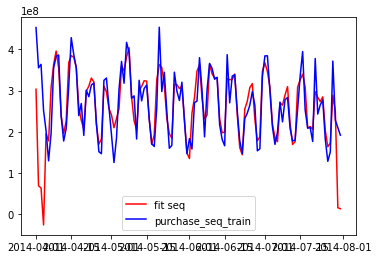

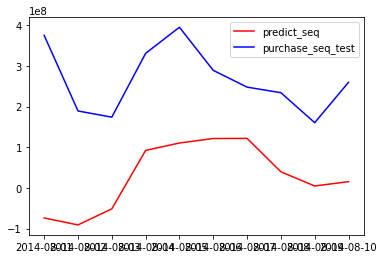

In [ ]:
dateparse = lambda dates: datetime.datetime.strptime(dates, "%Y-%m-%d")
purchase_seq_train = pd.read_csv('purchase_seq_train.csv', parse_dates=['report_date'],index_col='report_date', date_parser=dateparse)
purchase_seq_test = pd.read_csv('purchase_sqp_test.csv', parse_dates=['report_date'],index_col='report_date', date_parser=dateparse)

decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

# qushi xulie moxing xunlian
trend_model = ARIMA_Model(trend, (1,0,0))
trend_fit_seq = trend_model.fittedvalues
trend_predic_seq = trend_model.predict(start='2014-08-01', end='2014-08-10', dynamic=True)

residual_model = ARIMA_Model(residual, (2,0,1))
residual_fit_seq = residual_model.fittedvalues
residual_predic_seq = residual_model.predict(start='2014-08-01', end='2014-08-10', dynamic=True)

# nihe xunlian ji
fit_seq = pd.Series(seasonal['value'], index=seasonal.index)
fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

plt.plot(fit_seq, color='red', label='fit seq')
plt.plot(purchase_seq_train, color='blue', label='purchase_seq_train')
plt.legend(loc='best')
plt.show()

# yuce ceshiji
seasonal_predict_seq = seasonal['2014-04-04':'2014-04-13']

predict_dates = pd.Series(['2014-08-01','2014-08-02','2014-08-03',\
                           '2014-08-04','2014-08-05','2014-08-06','2014-08-07','2014-08-08','2014-08-09','2014-08-10']).\
                           apply(lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d'))
seasonal_predict_seq.index = predict_dates

predict_seq = pd.Series(seasonal_predict_seq['value'], index=seasonal_predict_seq.index)
predict_seq = predict_seq.add(trend_predic_seq, fill_value=0)
predict_seq = predict_seq.add(residual_predic_seq, fill_value=0)

plt.plot(predict_seq, color='red', label='predict_seq')
plt.plot(purchase_seq_test, color='blue', label='purchase_seq_test')
plt.legend(loc='best')
plt.show()

**结语**  
从结果上来看，模型拟合的效果还是不错的；在测试集上，模型基本预测了序列的趋势和波动。  
实际上，这样的数据集并不适合ARIMA模型来拟合（序列的（线性）自相关性不强，受随机噪声影响较大）。
